In [2]:
# Fix for importing utils
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.dirname(os.path.dirname(SCRIPT_DIR)))
from analysis.utils import utils

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display
np.set_printoptions(suppress=True, formatter={'float_kind':'{:f}'.format})

# Visualization of ZPOS Data

Expects folder tree structure of

```
./
|- 02_Pozyx_Positioning_Data
|   |-KITCHEN
|   |-ZPOS
|
|- 03_Labels
    |-KITCHEN
    |-ZPOS
```
- Sitting was at around 10cm off of the ground. Standing was at around 1.6m


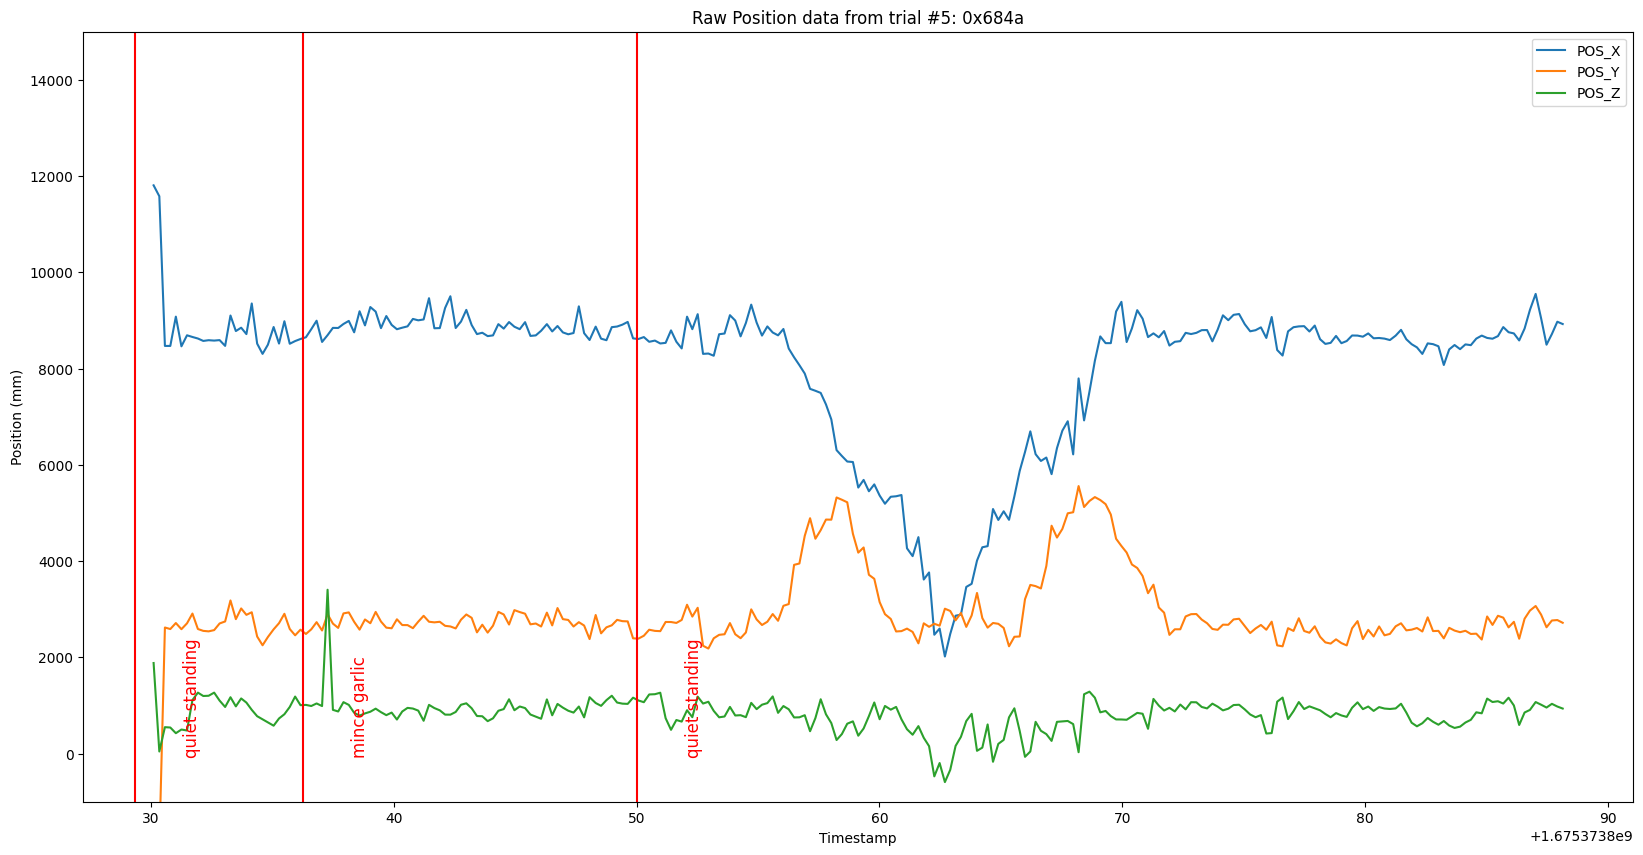

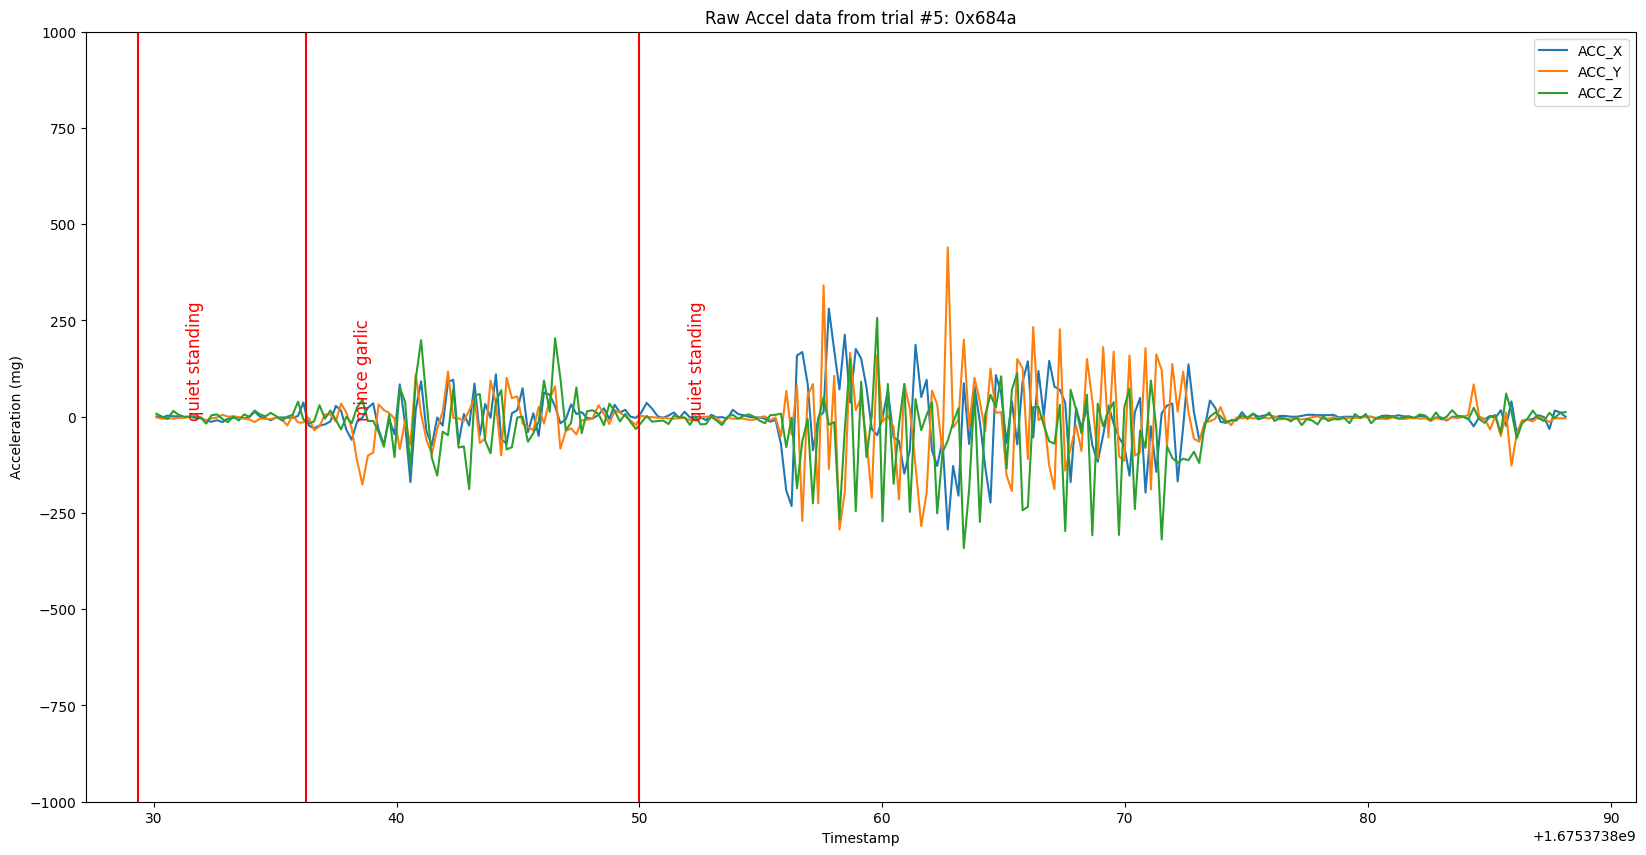

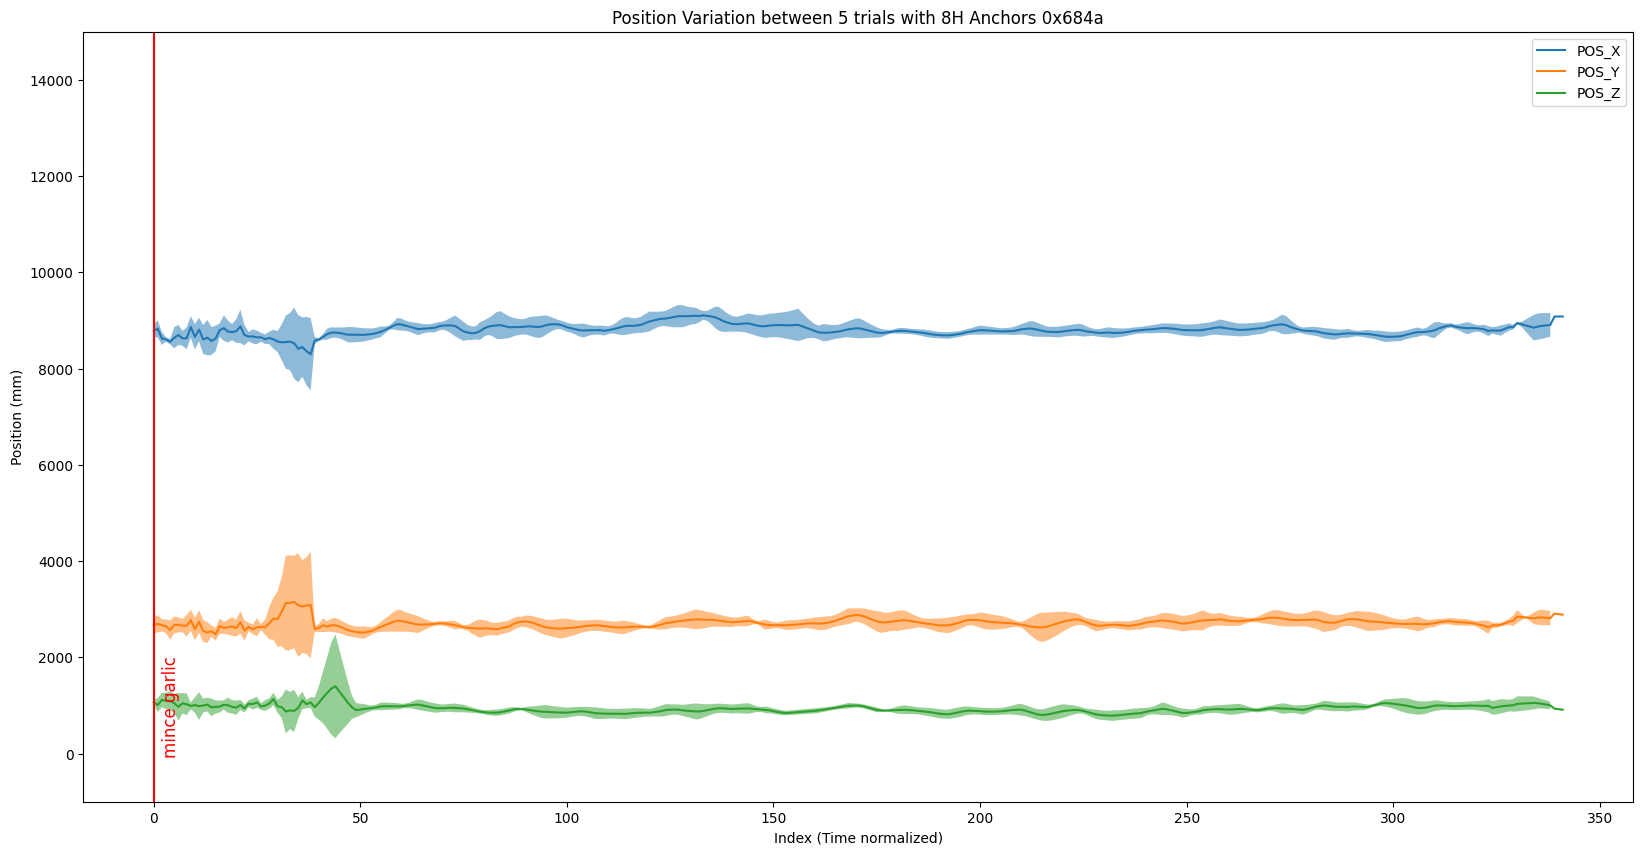

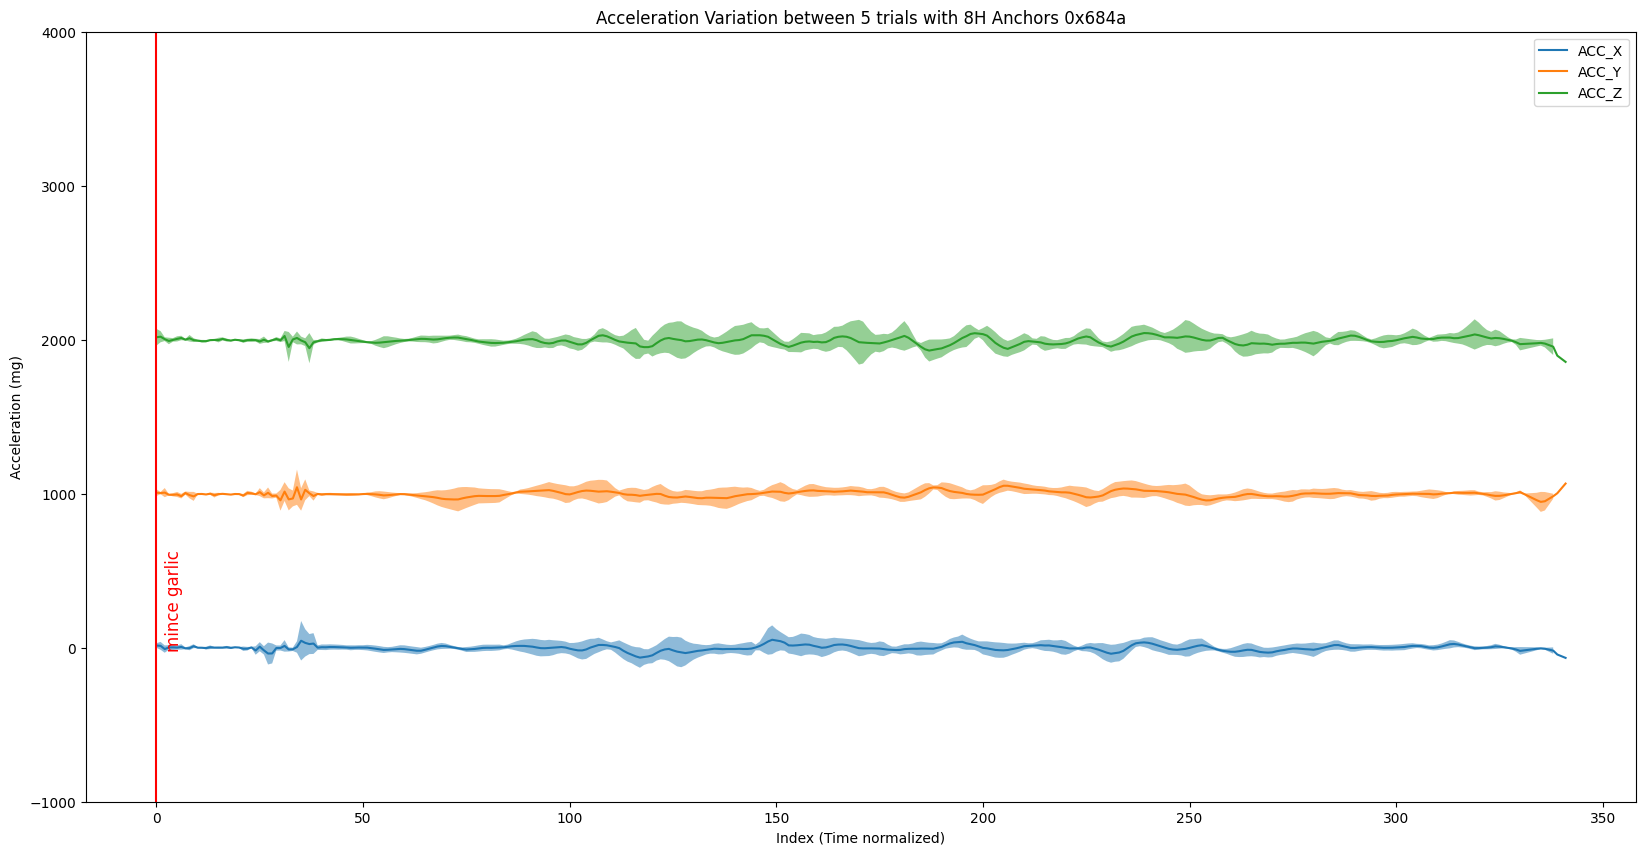

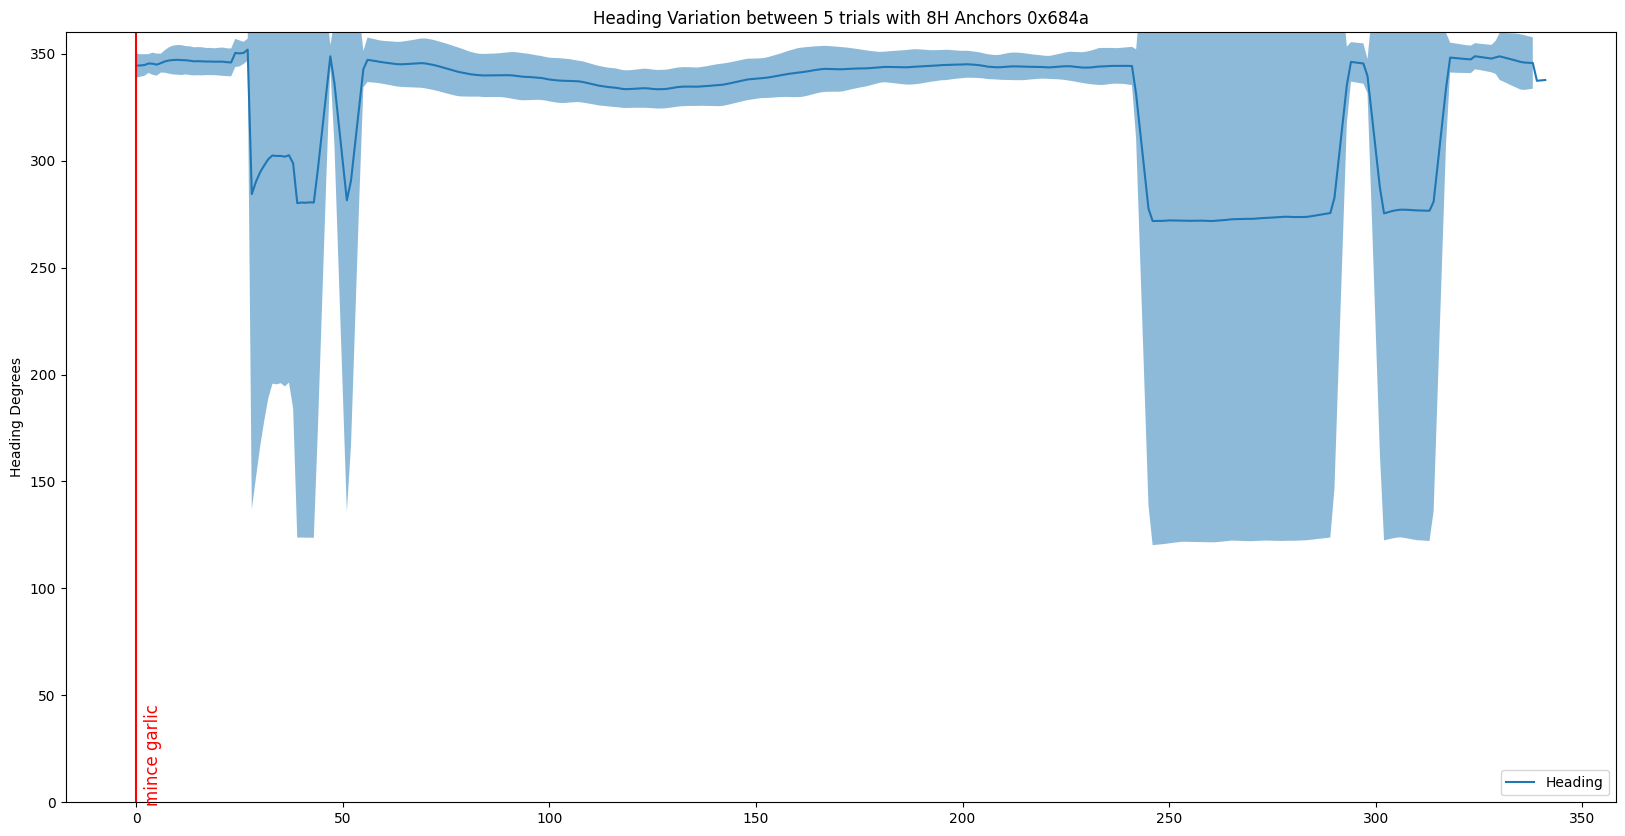

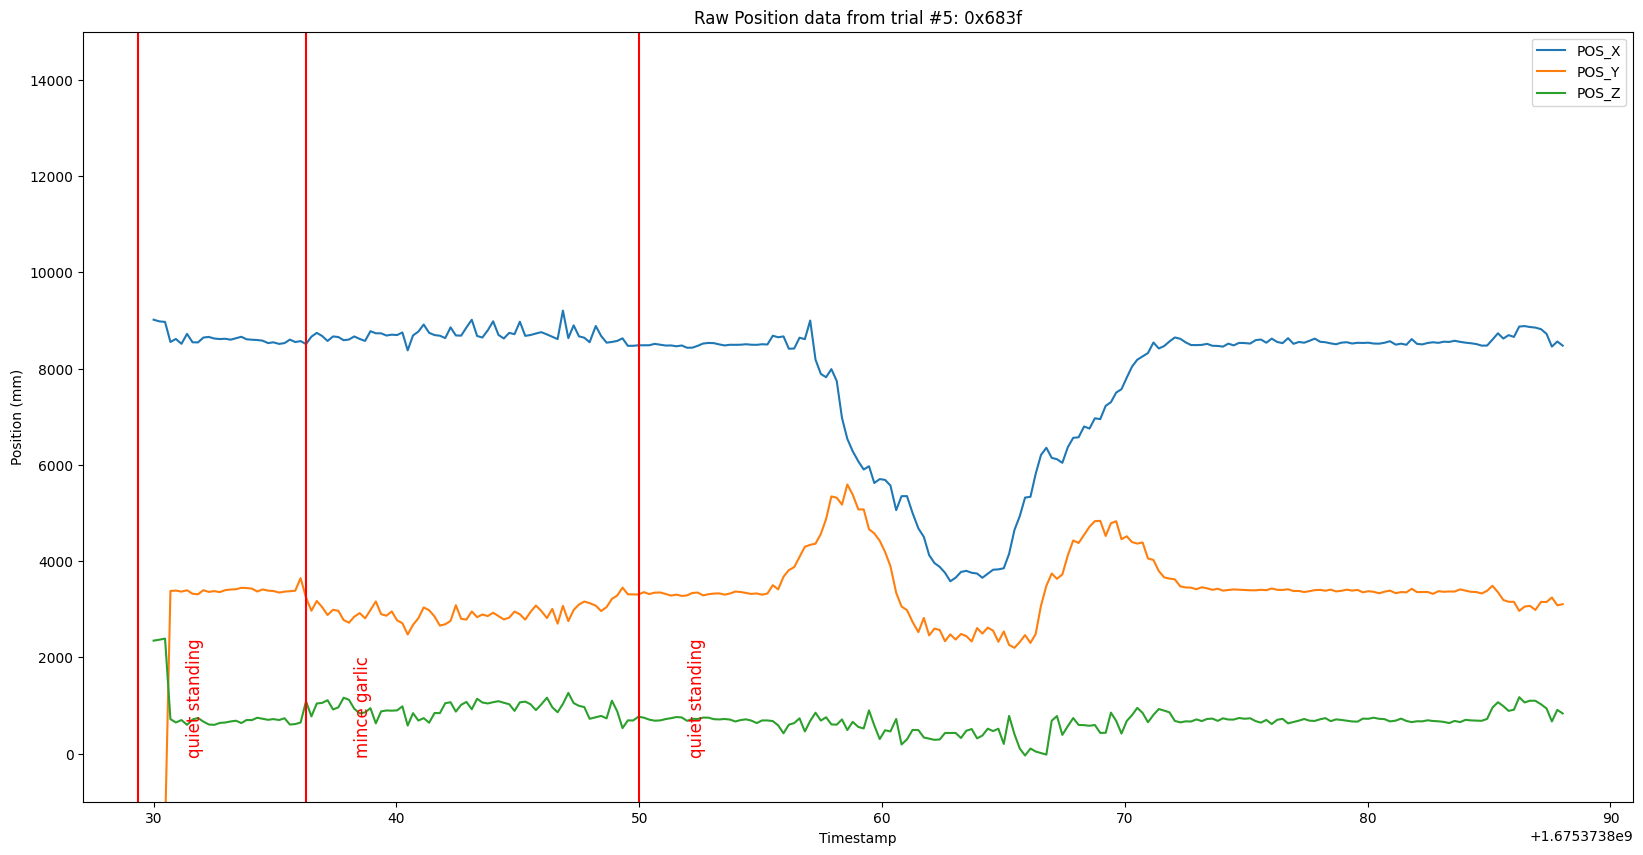

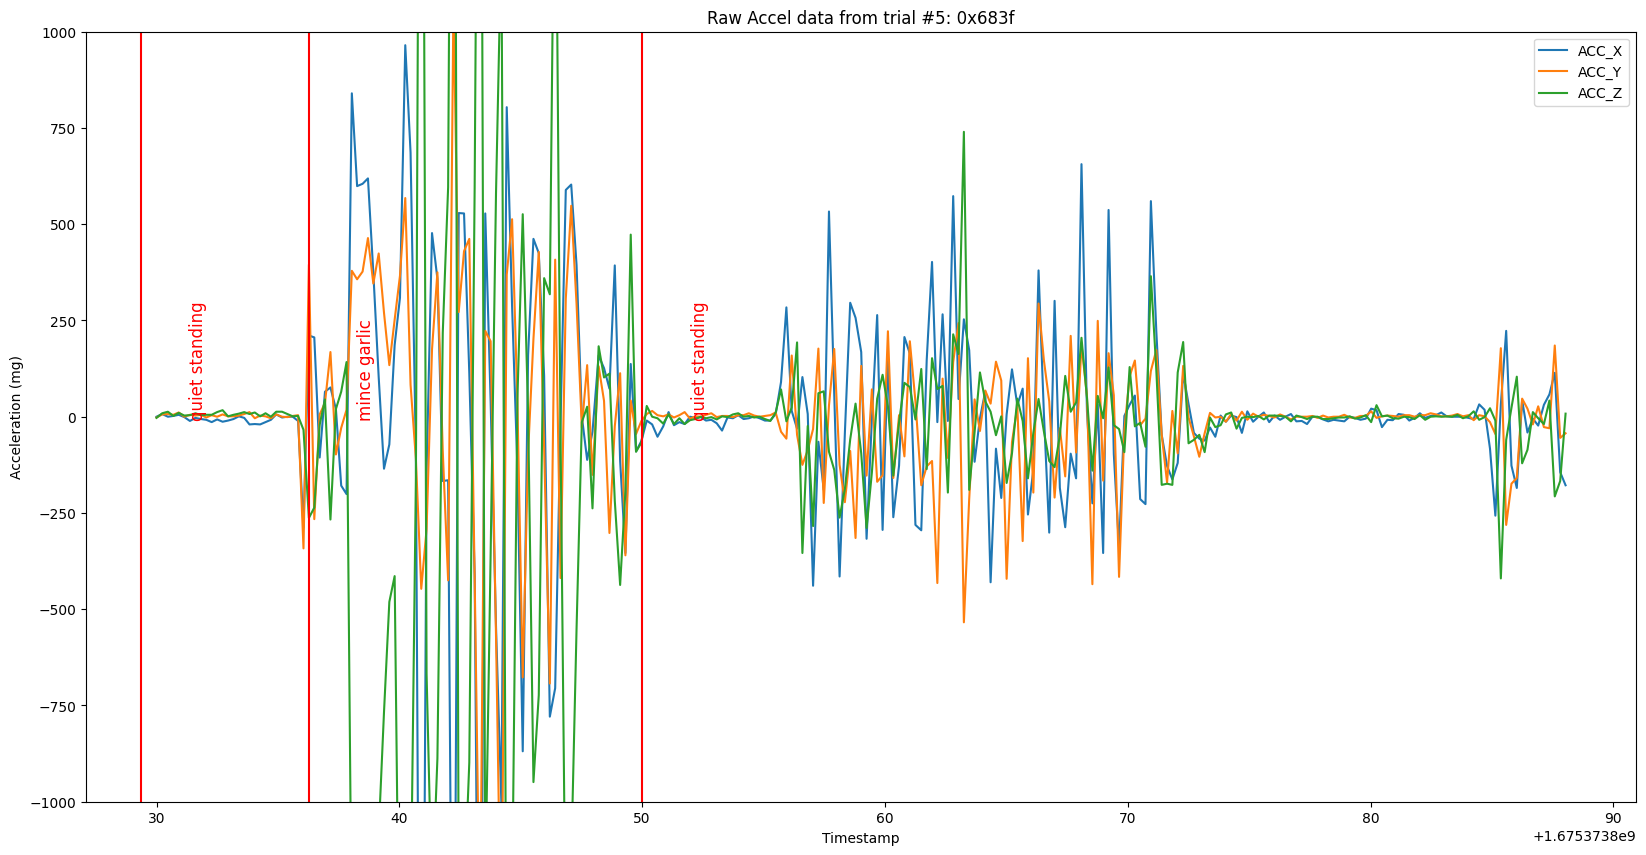

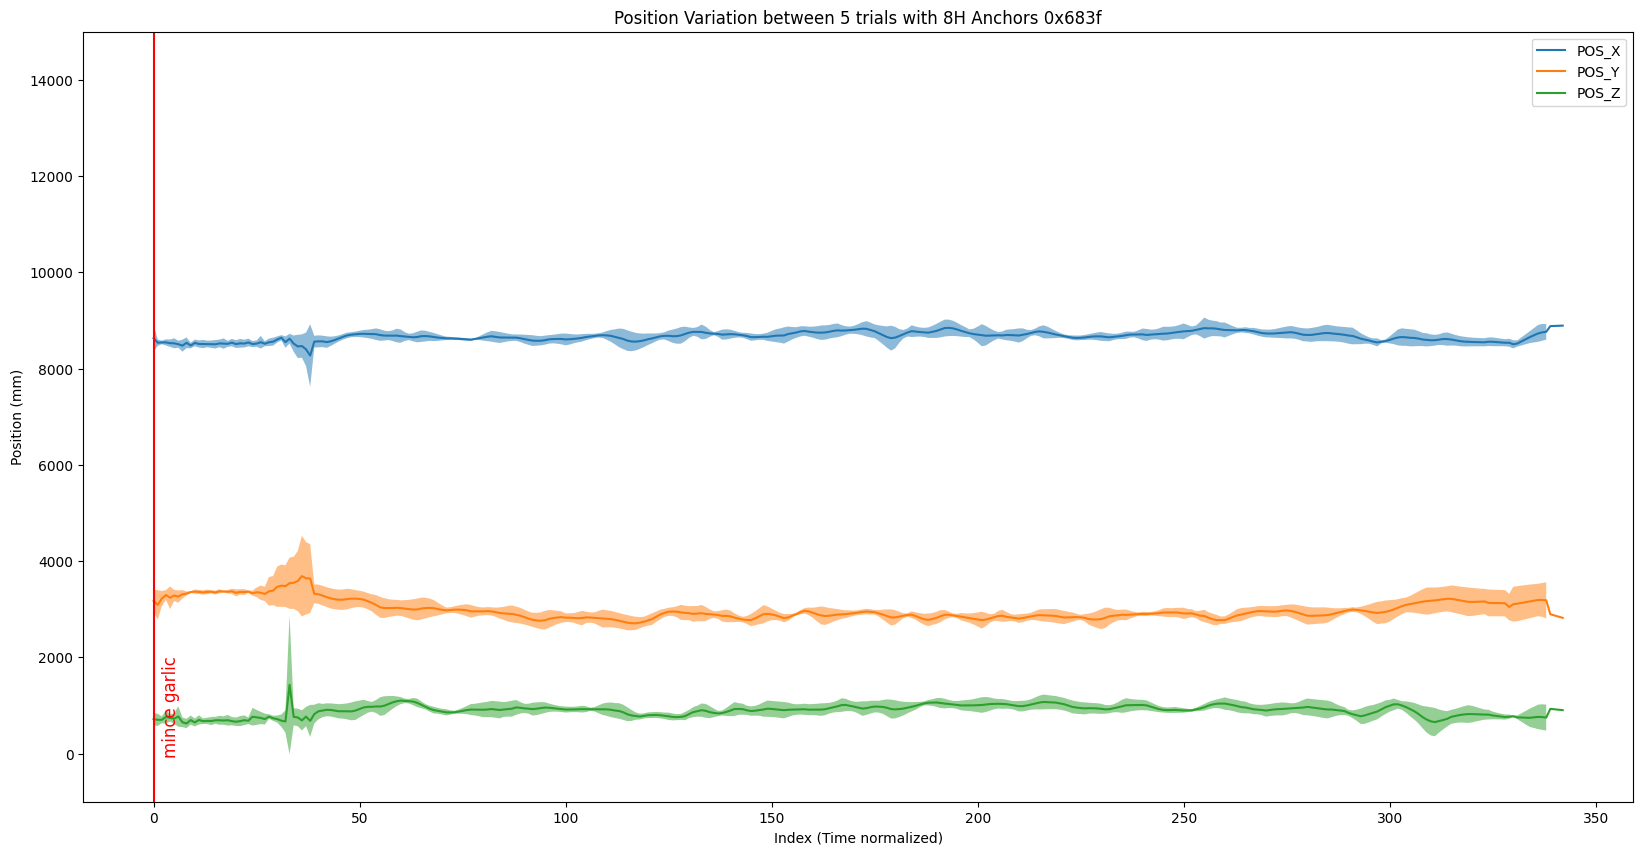

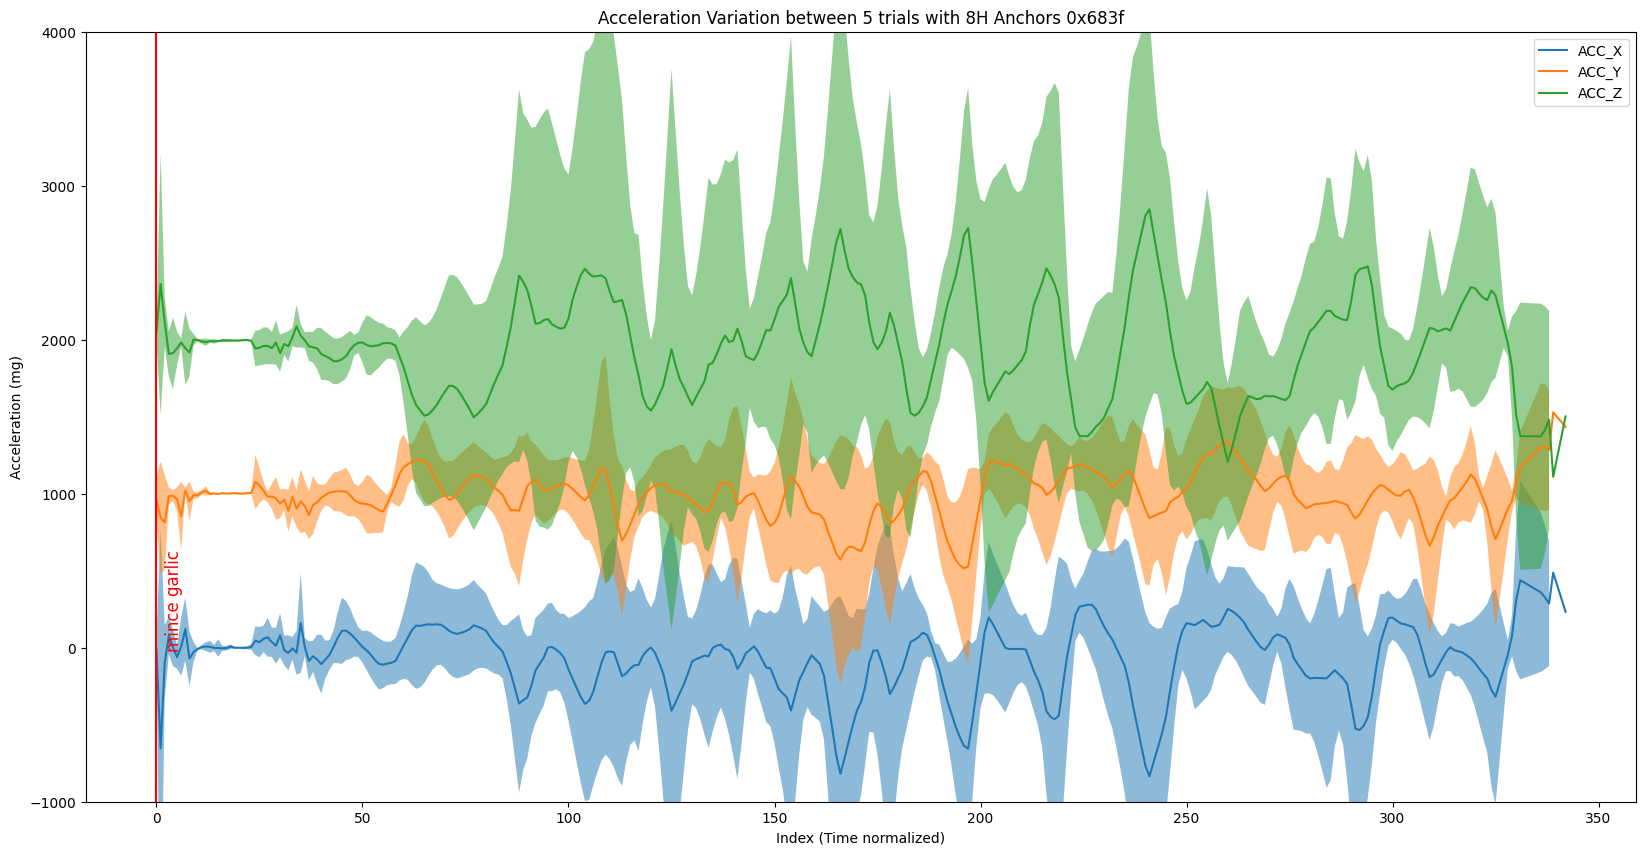

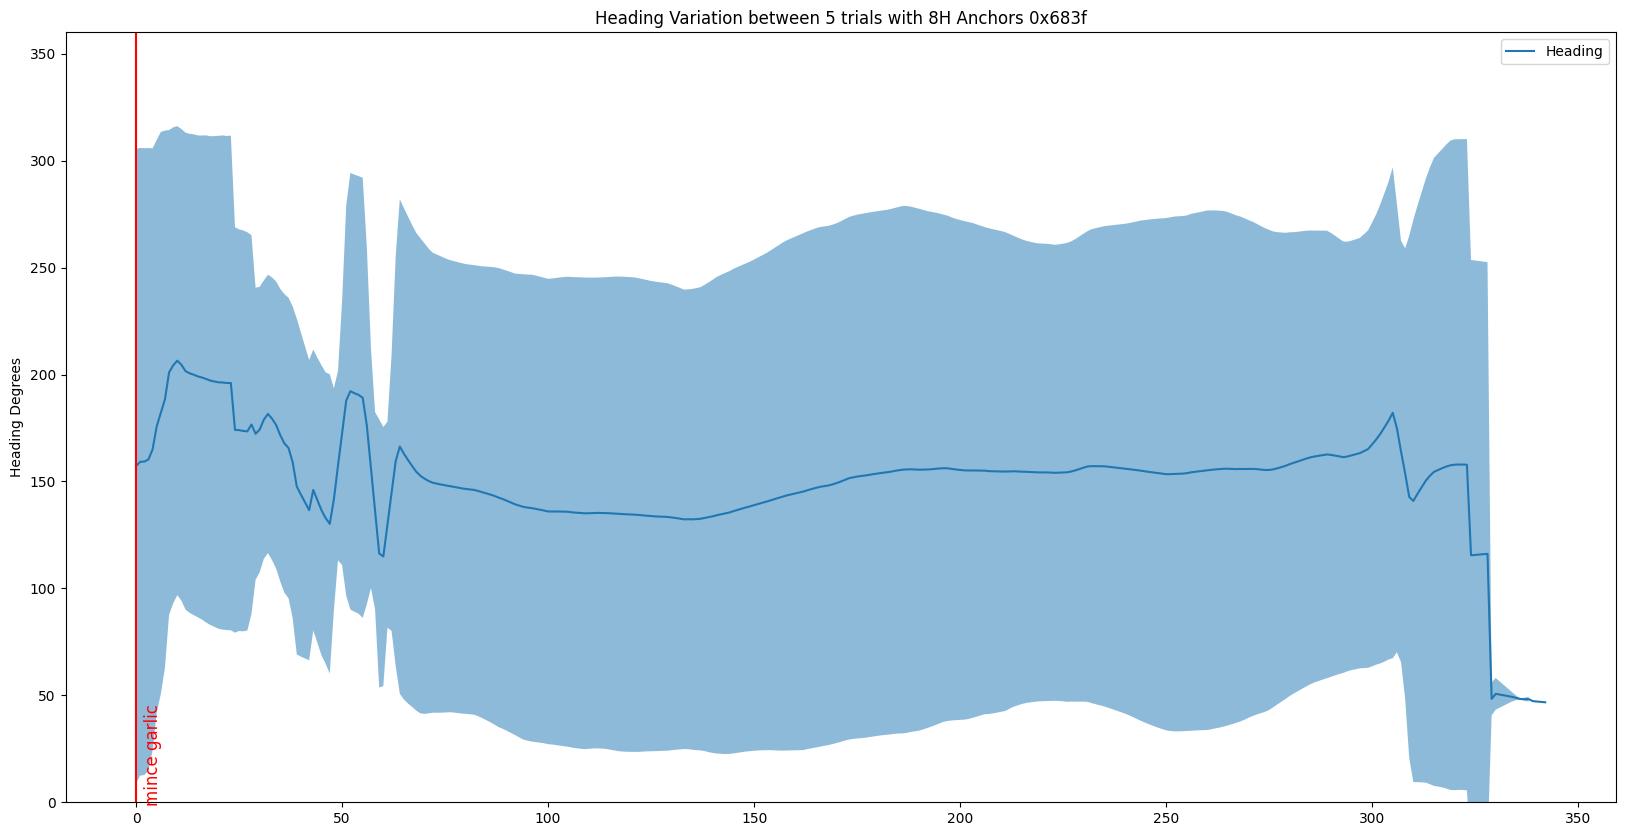

In [5]:
labels_dir = "03_Labels"
data_dir = "02_Pozyx_Positioning_Data"
NUM_NORM_POINTS = 300
TRIAL_NUM = 5
ANCHOR_CONFIG = ["8H"]
TYPE = "MINCEGARLIC"
TAG_ID =  ["0x684a", "0x683f"]

%matplotlib inline
for anchor in ANCHOR_CONFIG:
    for tagId in TAG_ID:
        processed_trials = pd.DataFrame()
        for trial in range(TRIAL_NUM):
            ANCHORS = anchor
            TRIAL = trial+1

            label_fn = f"{TYPE}_A{ANCHORS}_{TRIAL}.txt"
            data_fn = f"{TYPE}_A{ANCHORS}_{TRIAL}.csv"

            label_fp = Path('.').joinpath(labels_dir, TYPE, label_fn)
            data_fp = Path('.').joinpath(data_dir, TYPE, data_fn)

            labels = utils.extract_time_labels(label_fp)

            data = pd.read_csv(data_fp)
            data.columns = ['Timestamp', 'POS_X', 'POS_Y', 'POS_Z', 'Heading', 'Pitch', 'Roll', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TagId']
            data = data.set_index('Timestamp')


            data = data[data["TagId"] == tagId]
            data = data.drop("TagId", axis=1)

            # Segment the data into only the action portions.
            start_move_around = list(filter(lambda x: x["Label"] == "move around", labels))[0]['Timestamp']
            labels = list(filter(lambda x: float(x["Timestamp"]) < float(start_move_around), labels))

            moving_periods = [[float(start['Timestamp']), float(end['Timestamp'])] for (start, end) in zip(labels[1::2], labels[2::2])]
            moving_periods = filter(lambda x: float(x[1]) < float(start_move_around), moving_periods)
            standing_periods = [[float(start['Timestamp']), float(end['Timestamp'])] for (start, end) in zip(labels[0::2], labels[1::2])]

            ##################### CLEANING THE DATA ########################## 
            cleaned_data = (data
                            .loc[:start_move_around, :]
                            .pipe(utils.remove_periods, standing_periods)
                            .pipe(utils.interp1d_periods, moving_periods, num_points=NUM_NORM_POINTS)
                            .reset_index(drop=True)
                        )
            ##################################################################

            processed_trials = pd.concat([processed_trials, cleaned_data], axis=0)

        # To normalize in time, drop the index and fix the indexing (make start overlap with 10sec end)
        index = 0
        drop_index_labels = []
        for ind, _ in enumerate(labels[1::2]):
            drop_index_labels.append({'Timestamp': index, 'Label': labels[ind*2+1]['Label']})
            index += NUM_NORM_POINTS

        # Means and Standard deviations for ensemble averages
        means = processed_trials.groupby(processed_trials.index).mean()
        stds = processed_trials.groupby(processed_trials.index).std()

        # Stagger the means of the ACC_Y and ACC_Z
        means["ACC_Y"] += 1000
        means["ACC_Z"] += 2000


        # Raw Pos Data
        ax = utils.plot_pozyx_data_with_timings(data, ['POS_X','POS_Y','POS_Z'], labels)
        ax.set_title(f"Raw Position data from trial #{trial+1}: {tagId}")

        # Raw Acc Data
        ax = utils.plot_pozyx_data_with_timings(data, ['ACC_X','ACC_Y','ACC_Z'], labels, ylim=(-1000, 1000), ylabel="Acceleration (mg)")
        ax.set_title(f"Raw Accel data from trial #{trial+1}: {tagId}")

        # Position
        ax = utils.plot_pozyx_data_with_timings(means, ['POS_X', 'POS_Y', 'POS_Z'], drop_index_labels)
        ax.fill_between(means.index, means['POS_X'] + stds['POS_X'], means['POS_X'] - stds['POS_X'], alpha=0.5)
        ax.fill_between(means.index, means['POS_Y'] + stds['POS_Y'], means['POS_Y'] - stds['POS_Y'], alpha=0.5)
        ax.fill_between(means.index, means['POS_Z'] + stds['POS_Z'], means['POS_Z'] - stds['POS_Z'], alpha=0.5)
        ax.set_title(f"Position Variation between {TRIAL_NUM} trials with {ANCHORS} Anchors {tagId}")
        ax.set_xlabel("Index (Time normalized)")

        # Acceleration
        ax = utils.plot_pozyx_data_with_timings(means, ['ACC_X','ACC_Y','ACC_Z'], drop_index_labels, ylim=(-1000,4000), ylabel="Acceleration (mg)")
        ax.fill_between(means.index, means['ACC_X'] + stds['ACC_X'], means['ACC_X'] - stds['ACC_X'], alpha=0.5)
        ax.fill_between(means.index, means['ACC_Y'] + stds['ACC_Y'], means['ACC_Y'] - stds['ACC_Y'], alpha=0.5)
        ax.fill_between(means.index, means['ACC_Z'] + stds['ACC_Z'], means['ACC_Z'] - stds['ACC_Z'], alpha=0.5)
        ax.set_title(f"Acceleration Variation between {TRIAL_NUM} trials with {ANCHORS} Anchors {tagId}")
        ax.set_xlabel("Index (Time normalized)")

        # Heading
        ax = utils.plot_pozyx_data_with_timings(means, ['Heading'], drop_index_labels, ylim=(0, 360), ylabel="Heading Degrees")
        ax.fill_between(means.index, means['Heading'] + stds['Heading'], means['Heading'] - stds['Heading'], alpha=0.5)
        ax.set_title(f"Heading Variation between {TRIAL_NUM} trials with {ANCHORS} Anchors {tagId}")